¡Sí! Es el artículo de **Víctor M. Guerrero (2007), *Time series smoothing by penalized least squares***: exactamente la formulación que escribiste, un **LS penalizado** que estima una tendencia $\{t_t\}$ imponiendo suavidad sobre diferencias de orden $d$:

$$
\min_{\{t_t\}}\ \sum_{t=1}^{N}(Z_t-t_t)^2 \;+\;\lambda\sum_{t=d+1}^{N}\big(\nabla^d t_t - m\big)^2,
$$

donde $\nabla^d$ es el operador de diferencias (Whittaker–Henderson/HP como casos límite). La aportación clave es **permitir $m\neq 0$** (no forzar media cero de $\nabla^d t_t$) y dar una **solución estadística cerrada** (GLS) con **matriz de errores** y un **índice de suavidad** que te permite escoger $\lambda$ por objetivo de “porcentaje de suavidad”.&#x20;

# Solución cerrada (forma matricial)

Sea $K_d$ la matriz de diferencias de orden $d$ (con fila base $k_d=[(-1)^d\binom{d}{d},\ldots,\binom{d}{0}]$) y $V=\mathrm{Var}(g)$ la covarianza del ruido de observación de $Z_t=t_t+g_t$. Entonces

$$
\widehat{\mathbf t}
=\big(V^{-1}+\lambda K_d'K_d\big)^{-1}\!\Big(V^{-1}\mathbf Z+\lambda\, m\, K_d'\mathbf 1\Big),\qquad
\mathrm{MSE}(\widehat{\mathbf t})
=\sigma_Z^2\big(V^{-1}+\lambda K_d'K_d\big)^{-1}.
$$

Con $V=I$ recuperas **exponential smoothing** ($d=1$) y **Hodrick–Prescott** ($d=2$). Guerrero muestra además que $K_d'\mathbf 1$ **solo pesa en los $d$ extremos**, de modo que aparece un **ajuste implícito en bordes** (mejor comportamiento estadístico en los extremos que el HP “ingenuo”).&#x20;

# Estimadores auxiliares y varianza

* **Media en diferencias**: $ \widehat m=\frac{1}{N-d}\mathbf 1' K_d \mathbf Z$. Sustituyendo $m$ por $\widehat m$, la solución queda

$$
\widehat{\mathbf t}=(I+\lambda K_d'K_d)^{-1}\Big[I+\frac{\lambda}{N-d}\,K_d'\mathbf 1\,\mathbf 1'K_d\Big]\mathbf Z .
$$

* **Varianza del ruido** (corregida por estimar $m$):

$$
\widehat{\sigma}_Z^2=\frac{\sum_{t}(Z_t-\widehat t_t)^2+\lambda\sum_{t}(\nabla^d \widehat t_t-\widehat m)^2}{N-d-1}.
$$

Advertencia: **suponer $m=0$ cuando no lo es subestima $\sigma_Z^2$** en un término que crece con $\lambda m^2$.&#x20;

# Índice de suavidad y elección de $\lambda$

Define la **precisión total** $S^{-1}=\sigma_Z^{-2}I+\sigma_\varepsilon^{-2}K_d'K_d$ y el **índice de suavidad** (proporción de precisión aportada por el término de suavidad):

$$
S_d(\lambda,N) \;=\;
\begin{cases}
\lambda/(1+\lambda), & d=0,\\[3pt]
1-\dfrac{1}{N}\operatorname{tr}\big[(I+\lambda K_d'K_d)^{-1}\big], & d\ge 1.
\end{cases}
$$

Fijas $S_d\in(0,1)$ (p.ej. 60%, 90%) y **resuelves $\lambda$**; Guerrero incluso tabula ejemplos y discute cómo $S_d$ depende de $N$.&#x20;

# Pronóstico de la tendencia

Si el proceso en diferencias $\nabla^d t_t$ es estacionario alrededor de $m$, los **pronósticos fuera de muestra** de la tendencia siguen un polinomio en $h$ cuyo grado depende de $d$:

* $d=0$: $\widehat t_{N}(h)=m$.
* $d=1$: $\widehat t_{N}(h)=\widehat t_N + h\,m$.
* $d=2$: $\widehat t_{N}(h)=\frac{h(h+1)}{2}m + (h+1)\widehat t_N - h\,\widehat t_{N-1}$.
  (esto explica la extrapolación más “agresiva” del HP, $d=2$).&#x20;

# Lectura hermenéutica breve

* **Ontología del filtro**: la tendencia es el **estimador MMSE** de un componente latente sometido a una **penalización de curvatura de orden $d$**; el parámetro $m$ re-centra la dinámica de $\nabla^d t_t$.
* **Ética del borde**: el término $K_d'\mathbf 1$ institucionaliza una **corrección de extremos**; no es “truco numérico”, es consecuencia de la proyección lineal óptima.
* **Epistemología de $\lambda$**: en vez de adivinar $\lambda$, eliges la **suavidad objetivo** $S_d$ y la conviertes en $\lambda$; comparabilidad entre muestras y series.

Si quieres, lo implemento en Python tal cual (cálculo de $K_d$, $S_d(\lambda,N)$, elección de $\lambda$ por “suavidad objetivo”, $\widehat{\mathbf t}$, bandas $\pm 2\,\mathrm{se}$ y *forecasts* para $d=0,1,2$).&#x20;


λ elegido por S_target=0.900 → λ≈179.183


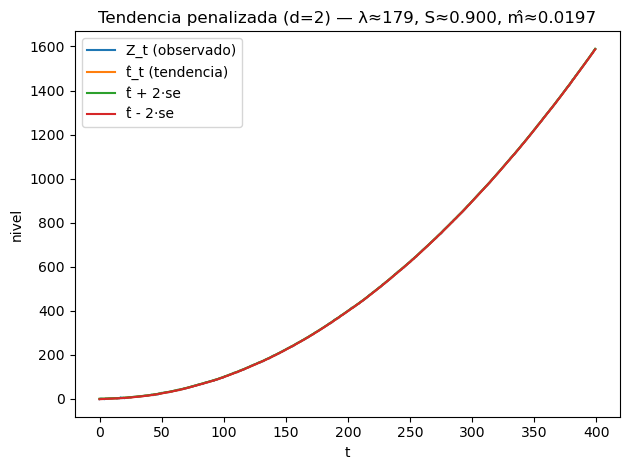

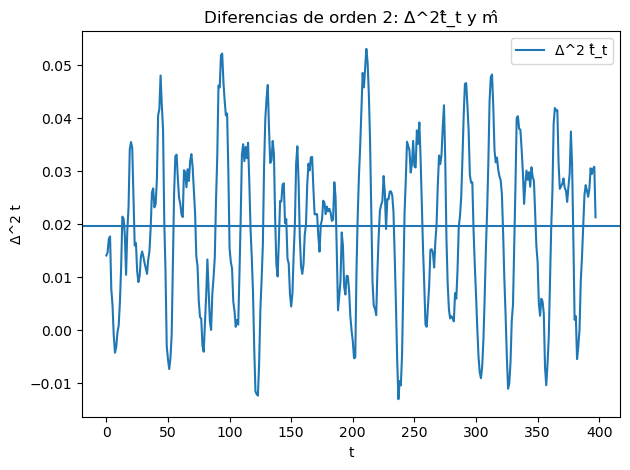

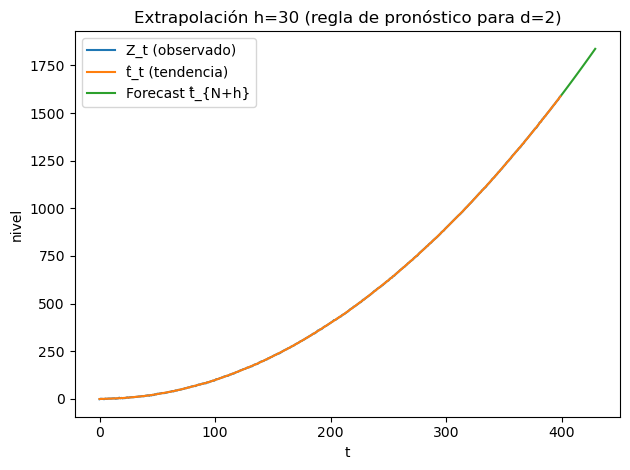

=== Resumen Guerrero (LS penalizado) ===
d = 2
λ (elegido por S_target) ≈ 179.183
S (índice de suavidad)  ≈ 0.900000
m̂ ≈ 0.019651
σ̂^2 ≈ 1.000549
Nota: bandas ±2·se usan Var(t̂) = σ̂^2 (I + λ K'K)^(-1)


In [2]:
# -*- coding: utf-8 -*-
"""
Implementación didáctica del suavizamiento por Mínimos Cuadrados Penalizados (Guerrero, 2007)
----------------------------------------------------------------------------------------------
Problema:
    min_{t_1,...,t_N, m}  sum_{t=1}^N (Z_t - t_t)^2 + λ * sum_{t=d+1}^N (Δ^d t_t - m)^2

- Soporta d = 0, 1, 2 (casos más usados; extensible).
- Estima simultáneamente la tendencia {t_t} y el parámetro m mediante un esquema de punto fijo
  (es equivalente a resolver el sistema normal con un ajuste de rango 1).
- Permite elegir λ directamente o por "índice de suavidad" objetivo S_d(λ,N):
      S_d(λ,N) = 1 - (1/N) * tr( (I + λ K'K)^(-1) )   (para d>=1)
      S_0(λ,N)  = λ / (1 + λ)
  y encuentra λ por búsqueda binaria.

- Entrega bandas de ±2*se con Var( t̂ ) = σ̂^2 * (I + λ K'K)^(-1),
  donde σ̂^2 = [ RSS + λ * penalización ] / (N - d - 1)

- Forecasts fuera de muestra (h pasos), según d:
   d=0:  t_{N+h} = m̂
   d=1:  t_{N+h} = t_N + h m̂
   d=2:  t_{N+h} = ((h*(h+1))/2)*m̂ + (h+1)t_N - h t_{N-1}

Visualizaciones:
  (1) Serie Z_t y tendencia t̂_t con bandas ±2 se
  (2) Diferencias Δ^d t̂_t con línea en m̂
  (3) Extrapolación (horizon=h_fore) con la regla de arriba

No usa seaborn. Una figura por gráfico. Sin especificar colores.
"""

import numpy as np
import matplotlib.pyplot as plt

# ----------------------- Operadores de diferencia -----------------------
def difference_matrix(N: int, d: int):
    """
    Devuelve la matriz K (N-d) x N tal que (K @ t)_t = Δ^d t_t, t=d+1..N.
    Convención: Δ t_t = t_t - t_{t-1}; Δ^2 t_t = Δ(Δ t_t), etc.
    """
    if d < 0 or d > 5:
        raise ValueError("Esta demo soporta 0<=d<=5; típicamente d in {0,1,2}.")
    if d == 0:
        # Δ^0 t_t = t_t  (pero solo penalizamos desde t=1..N; para d=0 N-d=N)
        K = np.eye(N)
        return K
    # Construir K por convolución de diferencias
    K = np.zeros((N - d, N))
    # Base: vector de coeficientes de Δ^d (binomios alternantes)
    coeffs = np.array([(-1)**(d-k) * comb(d, k) for k in range(d+1)], dtype=float)
    for row in range(N - d):
        K[row, row:row + d + 1] = coeffs
    return K

def comb(n, k):
    from math import comb as c
    return c(n, k)

# ----------------------- Núcleo del estimador -----------------------
def fit_penalized_trend(Z, d=2, lam=None, S_target=None, max_iter=100, tol=1e-10, verbose=False):
    """
    Estima (t_hat, m_hat) resolviendo:
        (I + λ K'K) t = Z + λ m K' 1,   con m = mean(K t)
    por iteración de punto fijo en m.

    Si S_target se da, calcula λ vía búsqueda binaria para el índice de suavidad objetivo.

    Retorna dict con:
        t_hat, m_hat, lam, S, sigma2_hat, Ainv (para errores), K, d
    """
    Z = np.asarray(Z, dtype=float).ravel()
    N = Z.size
    K = difference_matrix(N, d)
    I = np.eye(N)

    # Funciones auxiliares
    def A_inv_for_lambda(lam_):
        # Evita invertir explicitamente con np.linalg.inv si N grande: usar cho_factor/cho_solve
        from numpy.linalg import inv
        A = I + lam_ * (K.T @ K)
        return inv(A)  # Para demo; en producción usar factorización numéricamente estable.

    def smoothness_index(lam_):
        Ainv = A_inv_for_lambda(lam_)
        if d == 0:
            return lam_ / (1.0 + lam_)
        # S = 1 - (1/N) tr( (I + λ K'K)^(-1) )
        tr_val = np.trace(Ainv)
        return 1.0 - (tr_val / N)

    # Elegir λ
    if lam is None:
        if S_target is None:
            S_target = 0.90  # objetivo por defecto: 90% de "suavidad"
        # Búsqueda binaria en λ ∈ [λ_min, λ_max]
        lam_lo, lam_hi = 1e-9, 1e9
        for _ in range(60):
            lam_mid = np.sqrt(lam_lo * lam_hi)
            S_mid = smoothness_index(lam_mid)
            if S_mid < S_target:
                lam_lo = lam_mid
            else:
                lam_hi = lam_mid
        lam = lam_mid
        if verbose:
            print(f"λ elegido por S_target={S_target:.3f} → λ≈{lam:.6g}")

    # Iteración de m
    Ainv = A_inv_for_lambda(lam)
    K1 = K.T @ np.ones(K.shape[0])  # K' 1
    m = np.mean(K @ Z)  # inicialización razonable
    for it in range(max_iter):
        t_hat = Ainv @ (Z + lam * m * K1)
        m_new = np.mean(K @ t_hat)
        if abs(m_new - m) < tol:
            m = m_new
            break
        m = m_new
    else:
        if verbose:
            print("Aviso: iteración de m no convergió dentro de max_iter")

    # Estimación de sigma^2 (con corrección por m)
    resid = Z - t_hat
    pen  = K @ t_hat - m
    dof  = max(1, N - d - 1)
    sigma2_hat = (resid @ resid + lam * (pen @ pen)) / dof

    # Índice de suavidad resultante
    S_val = smoothness_index(lam)

    return {
        "t_hat": t_hat,
        "m_hat": float(m),
        "lam": float(lam),
        "S": float(S_val),
        "sigma2_hat": float(sigma2_hat),
        "Ainv": Ainv,
        "K": K,
        "d": int(d),
        "Z": Z
    }

# ----------------------- Pronóstico fuera de muestra -----------------------
def forecast_trend(t_hat, d, m_hat, h):
    """
    Pronósticos h pasos para la tendencia según la dinámica en diferencias.
    """
    t_hat = np.asarray(t_hat, dtype=float).ravel()
    N = t_hat.size
    if d == 0:
        return np.full(h, m_hat)
    if d == 1:
        return t_hat[-1] + m_hat * np.arange(1, h+1, dtype=float)
    if d == 2:
        # t_{N+h} = ((h(h+1))/2) m + (h+1) t_N - h t_{N-1}
        tN = t_hat[-1]; tNm1 = t_hat[-2]
        h_arr = np.arange(1, h+1, dtype=float)
        return ((h_arr*(h_arr+1))/2.0)*m_hat + (h_arr+1.0)*tN - h_arr*tNm1
    # fallback: extrapolación ingenua
    return np.full(h, t_hat[-1])

# ----------------------- Demo con datos sintéticos -----------------------
def synthetic_series(N=500, seed=123, d_trend=2, m_true=0.01, sigma=0.5):
    """
    Genera Z_t = t_t + g_t, con t_t que cumple Δ^d t_t ~ m_true y ruido g_t ~ N(0, sigma^2).
    """
    rng = np.random.default_rng(seed)
    t = np.zeros(N)
    if d_trend == 0:
        t[:] = m_true
    elif d_trend == 1:
        t[0] = 0.0
        for i in range(1, N):
            t[i] = t[i-1] + m_true
    elif d_trend == 2:
        t[0] = 0.0; t[1] = 0.0
        for i in range(2, N):
            # Δ^2 t_i = m_true  => t_i = 2 t_{i-1} - t_{i-2} + m_true
            t[i] = 2*t[i-1] - t[i-2] + m_true
    else:
        raise ValueError("Demo: d_trend debe ser 0,1,2.")
    g = rng.normal(0.0, sigma, size=N)
    Z = t + g
    return Z, t

# ----------------------- Ejecución de la demo -----------------------
# 1) Genera datos y ajusta
Z, t_true = synthetic_series(N=400, seed=2025, d_trend=2, m_true=0.02, sigma=1.0)

# Elige un objetivo de suavidad y ajusta con d=2
fit = fit_penalized_trend(Z, d=2, lam=None, S_target=0.90, verbose=True)

t_hat = fit["t_hat"]; m_hat = fit["m_hat"]; lam = fit["lam"]; S = fit["S"]
Ainv = fit["Ainv"]; sigma2_hat = fit["sigma2_hat"]; K = fit["K"]; d = fit["d"]

# Errores estándar y bandas ± 2*se
se = np.sqrt(np.maximum(0.0, sigma2_hat) * np.diag(Ainv))
upper = t_hat + 2.0 * se
lower = t_hat - 2.0 * se

# 2) Gráfico: Z vs t̂ con bandas
plt.figure()
plt.plot(Z, label="Z_t (observado)")
plt.plot(t_hat, label="t̂_t (tendencia)")
plt.plot(upper, label="t̂ + 2·se")
plt.plot(lower, label="t̂ - 2·se")
plt.title(f"Tendencia penalizada (d={d}) — λ≈{lam:.3g}, S≈{S:.3f}, m̂≈{m_hat:.4f}")
plt.xlabel("t"); plt.ylabel("nivel")
plt.legend(); plt.tight_layout(); plt.show()

# 3) Gráfico: Δ^d t̂_t vs m̂
plt.figure()
Kt = K @ t_hat
plt.plot(Kt, label=f"Δ^{d} t̂_t")
plt.axhline(m_hat)
plt.title(f"Diferencias de orden {d}: Δ^{d}t̂_t y m̂")
plt.xlabel("t"); plt.ylabel(f"Δ^{d} t"); plt.legend(); plt.tight_layout(); plt.show()

# 4) Pronósticos fuera de muestra
h_fore = 30
t_fore = forecast_trend(t_hat, d=d, m_hat=m_hat, h=h_fore)

plt.figure()
plt.plot(Z, label="Z_t (observado)")
plt.plot(t_hat, label="t̂_t (tendencia)")
x_fore = np.arange(len(Z), len(Z)+h_fore)
plt.plot(x_fore, t_fore, label="Forecast t̂_{N+h}")
plt.title(f"Extrapolación h={h_fore} (regla de pronóstico para d={d})")
plt.xlabel("t"); plt.ylabel("nivel"); plt.legend(); plt.tight_layout(); plt.show()

# 5) Imprime resumen
print("=== Resumen Guerrero (LS penalizado) ===")
print(f"d = {d}")
print(f"λ (elegido por S_target) ≈ {lam:.6g}")
print(f"S (índice de suavidad)  ≈ {S:.6f}")
print(f"m̂ ≈ {m_hat:.6f}")
print(f"σ̂^2 ≈ {sigma2_hat:.6f}")
print("Nota: bandas ±2·se usan Var(t̂) = σ̂^2 (I + λ K'K)^(-1)")
